In [2]:
import boto3
import sagemaker
import pandas as pd
import seaborn as sns
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
s3_client = boto3.client('s3', region_name='us-east-1')
bucket_name = 'team1ads508finalproject'

In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

s3_public = "s3://team1ads508finalproject"

s3_private = "s3://{}/ADS508_project".format(bucket)

!aws s3 cp --recursive $s3_public/ $s3_private/

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
copy: s3://team1ads508finalproject/application_train.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/application_train.csv
copy: s3://team1ads508finalproject/bureau.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/bureau.csv
copy: s3://team1ads508finalproject/previous_application.csv to s3://sagemaker-us-east-1-654654578488/ADS508_project/previous_application.csv


In [5]:
print(s3_private)

s3://sagemaker-us-east-1-654654578488/ADS508_project


In [6]:
%store

Stored variables and their in-db values:


In [7]:
database_name = "dsoaws"

In [8]:
#Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [9]:
conn = connect(region_name='us-east-1', s3_staging_dir=s3_staging_dir)

In [10]:
# SQL queries for each of the csv's
sql_queries = {
    'bureau': 'SELECT * FROM bureau LIMIT 30000',
    'previous_application': 'SELECT * FROM previous_application LIMIT 30000',
    'application': 'SELECT * FROM application LIMIT 30000'
}

# Fetch data and convert to DataFrames
bureau_df = pd.read_sql(sql_queries['bureau'], conn)
prev_app_df = pd.read_sql(sql_queries['previous_application'], conn)
app_df = pd.read_sql(sql_queries['application'], conn)

# Display each pandas Dataframe
print("bureau_df:")
print(bureau_df.head())

print("\nprev_app_df:")
print(prev_app_df.head())

print("\napp_df:")
print(app_df.head())

/tmp/ipykernel_5499/3237024562.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bureau_df = pd.read_sql(sql_queries['bureau'], conn)
/tmp/ipykernel_5499/3237024562.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prev_app_df = pd.read_sql(sql_queries['previous_application'], conn)
/tmp/ipykernel_5499/3237024562.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  app_df = pd.read_sql(sql_queries['application'], conn)


bureau_df:
   sk_id_curr  sk_id_bureau  credit_active  credit_currency  days_credit  \
0         NaN           NaN  CREDIT_ACTIVE  CREDIT_CURRENCY          NaN   
1    215354.0     5714462.0         Closed       currency 1       -497.0   
2    215354.0     5714463.0         Active       currency 1       -208.0   
3    215354.0     5714464.0         Active       currency 1       -203.0   
4    215354.0     5714465.0         Active       currency 1       -203.0   

   credit_day_overdue  days_credit_enddate  days_enddate_fact  \
0                 NaN                  NaN                NaN   
1                 0.0               -153.0             -153.0   
2                 0.0               1075.0                NaN   
3                 0.0                528.0                NaN   
4                 0.0                  NaN                NaN   

   amt_credit_max_overdue  cnt_credit_prolong  amt_credit_sum  \
0                     NaN                 NaN             NaN   
1          

In [11]:
# bureau_df check for duplicates
bureau_df = bureau_df.drop_duplicates()
print("Shape after removing duplicate:", bureau_df.shape)

Shape after removing duplicate: (30000, 17)


In [12]:
# prev_app_df check for duplicates
prev_app_df = prev_app_df.drop_duplicates()
print("Shape after removing duplicates:", prev_app_df.shape)

Shape after removing duplicates: (30000, 37)


In [13]:
#app_df check for duplicates
app_df = app_df.drop_duplicates()
print("Shape after removing duplicate:", app_df.shape)

Shape after removing duplicate: (30000, 122)


In [14]:
# Aggregate data for bureau_df
bureau_df_grouped = bureau_df.groupby('sk_id_curr').agg('first').reset_index()

# Aggregate data for prev_app_df
prev_app_df_grouped = prev_app_df.groupby('sk_id_curr').agg('first').reset_index()

# Aggregate data for app_df
app_df_grouped = app_df.groupby('sk_id_curr').agg('first').reset_index()

# Concat DataFrames
aggregated_df = pd.concat([bureau_df_grouped, prev_app_df_grouped, app_df_grouped], ignore_index=True)

print(aggregated_df.head())

   sk_id_curr  sk_id_bureau credit_active credit_currency  days_credit  \
0    100039.0     5153442.0        Active      currency 1        -91.0   
1    100045.0     5377608.0        Closed      currency 1       -733.0   
2    100053.0     5723577.0        Closed      currency 1      -1764.0   
3    100229.0     5309712.0        Closed      currency 1       -401.0   
4    100302.0     5307262.0        Active      currency 1       -231.0   

   credit_day_overdue  days_credit_enddate  days_enddate_fact  \
0                 0.0               1379.0            -1406.0   
1                 0.0               -337.0             -608.0   
2                 0.0               -648.0             -648.0   
3                 0.0               -279.0             -278.0   
4                 0.0               1595.0                NaN   

   amt_credit_max_overdue  cnt_credit_prolong  ...  flag_document_18  \
0                     NaN                 0.0  ...               NaN   
1                   

In [15]:
duplicates = aggregated_df.duplicated(subset=['sk_id_curr'])
print("Duplicate rows:", duplicates.sum())

Duplicate rows: 2652


In [16]:
final_df = aggregated_df.drop_duplicates()
duplicates = final_df.duplicated(subset=['sk_id_curr'])
print("Duplicate rows:", duplicates.sum())

Duplicate rows: 2652


In [17]:
print(aggregated_df.columns)

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=166)


In [18]:
bureau_df

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,NaN,NaN,CREDIT_ACTIVE,CREDIT_CURRENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CREDIT_TYPE,NaN,NaN
1,215354.0,5714462.0,Closed,currency 1,-497.0,0.0,-153.0,-153.0,NaN,0.0,91323.0,0.0,NaN,0.0,Consumer credit,-131.0,NaN
2,215354.0,5714463.0,Active,currency 1,-208.0,0.0,1075.0,NaN,NaN,0.0,225000.0,171342.0,NaN,0.0,Credit card,-20.0,NaN
3,215354.0,5714464.0,Active,currency 1,-203.0,0.0,528.0,NaN,NaN,0.0,464323.5,NaN,NaN,0.0,Consumer credit,-16.0,NaN
4,215354.0,5714465.0,Active,currency 1,-203.0,0.0,NaN,NaN,NaN,0.0,90000.0,NaN,NaN,0.0,Credit card,-16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,309764.0,5736660.0,Closed,currency 1,-617.0,0.0,-260.0,-254.0,NaN,0.0,73953.0,0.0,NaN,0.0,Consumer credit,-137.0,NaN
29996,309764.0,5736661.0,Closed,currency 1,-509.0,0.0,-198.0,-198.0,NaN,0.0,48541.5,0.0,NaN,0.0,Consumer credit,-175.0,NaN
29997,309764.0,5736662.0,Active,currency 1,-181.0,0.0,NaN,NaN,NaN,0.0,225000.0,NaN,NaN,0.0,Credit card,-25.0,NaN
29998,309764.0,5736663.0,Active,currency 1,-53.0,0.0,131.0,NaN,NaN,0.0,117000.0,110682.0,NaN,0.0,Consumer credit,-9.0,NaN


In [19]:
prev_app_df

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,1237099,136447,Consumer loans,10228.590,147955.50,155686.5,18000.00,147955.50,TUESDAY,7,...,Consumer electronics,24.0,middle,POS household with interest,365243.0,-1123.0,-433.0,-793.0,-784.0,0.0
1,2155628,387255,Consumer loans,14053.590,152834.84,135175.5,30569.85,152834.84,FRIDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-752.0,-422.0,-422.0,-410.0,0.0
2,1627218,430414,Consumer loans,5279.805,25065.00,26307.0,0.00,25065.00,WEDNESDAY,18,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-2438.0,-2288.0,-2288.0,-2283.0,1.0
3,1542738,194245,Consumer loans,7009.740,59265.00,48712.5,14265.00,59265.00,WEDNESDAY,12,...,20,NaN,10.0,high,NaN,365243.0,-2089.0,-1819.0,-1819.0,-1816.0
4,1606993,247611,Consumer loans,3049.695,21825.00,15075.0,6750.00,21825.00,SATURDAY,12,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-1594.0,-1444.0,-1474.0,-1471.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2689544,424241,Cash loans,48698.594,1129500.00,1227901.5,NaN,1129500.00,TUESDAY,13,...,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-881.0,169.0,365243.0,365243.0,1.0
29996,2037137,204574,Consumer loans,19490.715,189000.00,184693.5,18900.00,189000.00,FRIDAY,10,...,Industry,12.0,middle,POS industry with interest,365243.0,-651.0,-321.0,-321.0,-316.0,0.0
29997,1248824,351459,Consumer loans,11673.855,103491.00,103900.5,10350.00,103491.00,WEDNESDAY,10,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1438.0,-1168.0,-1168.0,-1163.0,0.0
29998,2191721,401992,Consumer loans,9286.515,106195.50,87034.5,27000.00,106195.50,SATURDAY,10,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-1678.0,-1348.0,-1588.0,-1584.0,0.0


In [20]:
app_df

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,NaN,NaN,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354.0,5714462.0,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354.0,5714463.0,Active,currency 1,-208,0,1075.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354.0,5714464.0,Active,currency 1,-203,0,528.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354.0,5714465.0,Active,currency 1,-203,0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,387301.0,0.0,Cash loans,M,Y,Y,0.0,112500.0,324000.0,15232.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
29996,387302.0,0.0,Revolving loans,F,N,Y,1.0,112500.0,247500.0,12375.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
29997,387303.0,0.0,Cash loans,F,Y,Y,0.0,247500.0,1066320.0,38430.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
29998,387304.0,0.0,Cash loans,F,N,Y,0.0,126000.0,481176.0,24732.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0


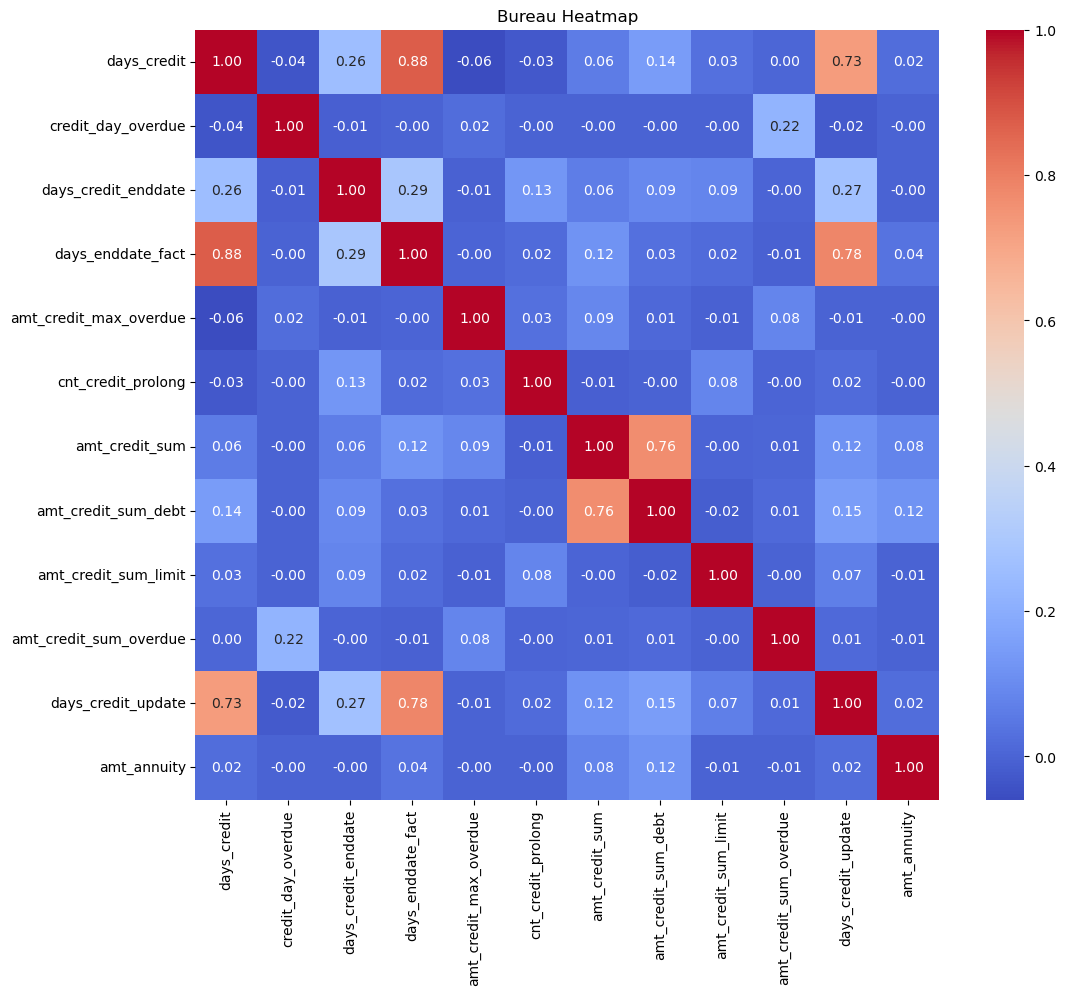

In [21]:
# Numerical columns for Bureau DF heatmap
numerical_columns = ['days_credit', 'credit_day_overdue', 'days_credit_enddate',
                     'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
                     'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
                     'amt_credit_sum_overdue', 'days_credit_update', 'amt_annuity']

subset_df = bureau_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create Bureau heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Bureau Heatmap')
plt.show()

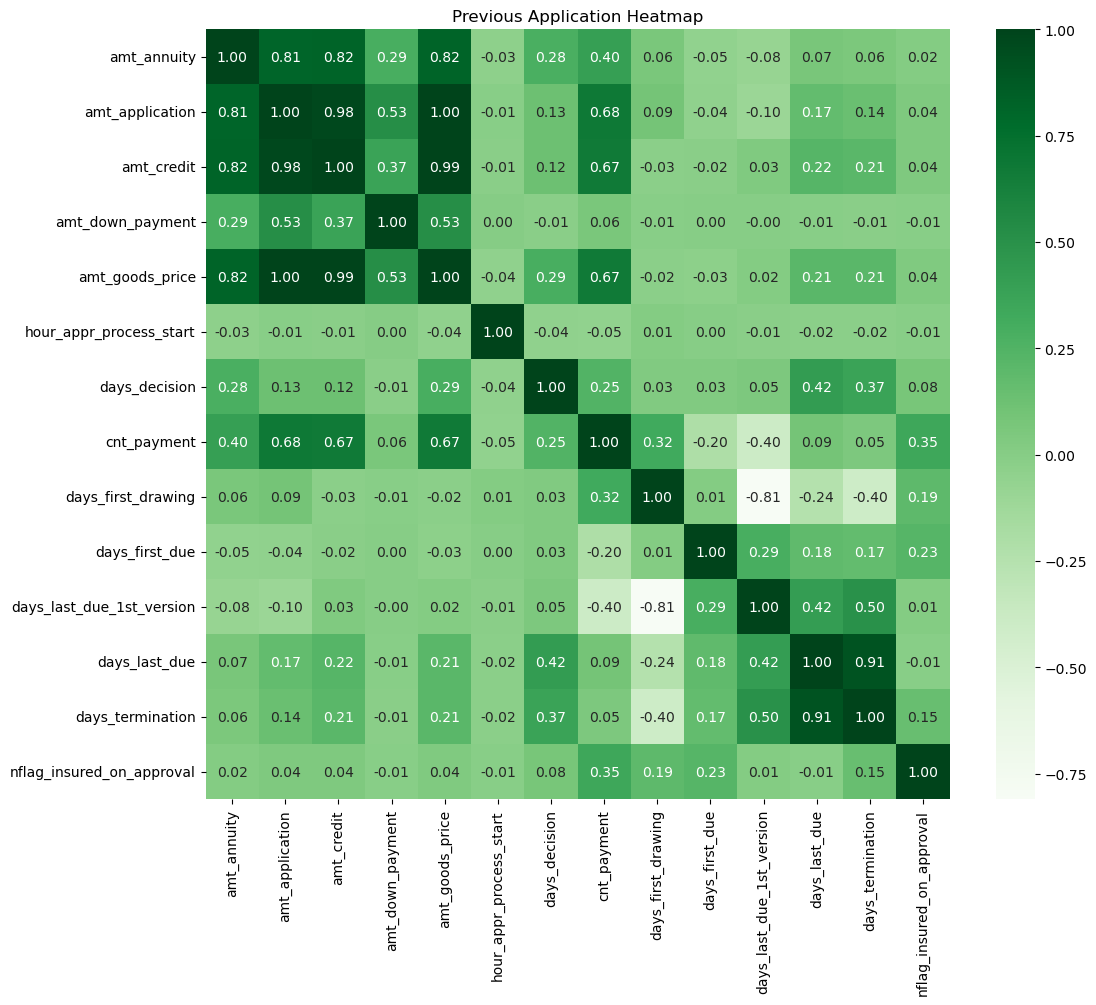

In [22]:
# Numerical columns for Previous App DF heatmap
numerical_columns = ['amt_annuity', 'amt_application', 'amt_credit', 'amt_down_payment',
                     'amt_goods_price', 'hour_appr_process_start', 'days_decision',
                     'cnt_payment', 'days_first_drawing', 'days_first_due',
                     'days_last_due_1st_version', 'days_last_due', 'days_termination',
                     'nflag_insured_on_approval']

subset_df = prev_app_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create a Previous App heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Previous Application Heatmap')
plt.show()

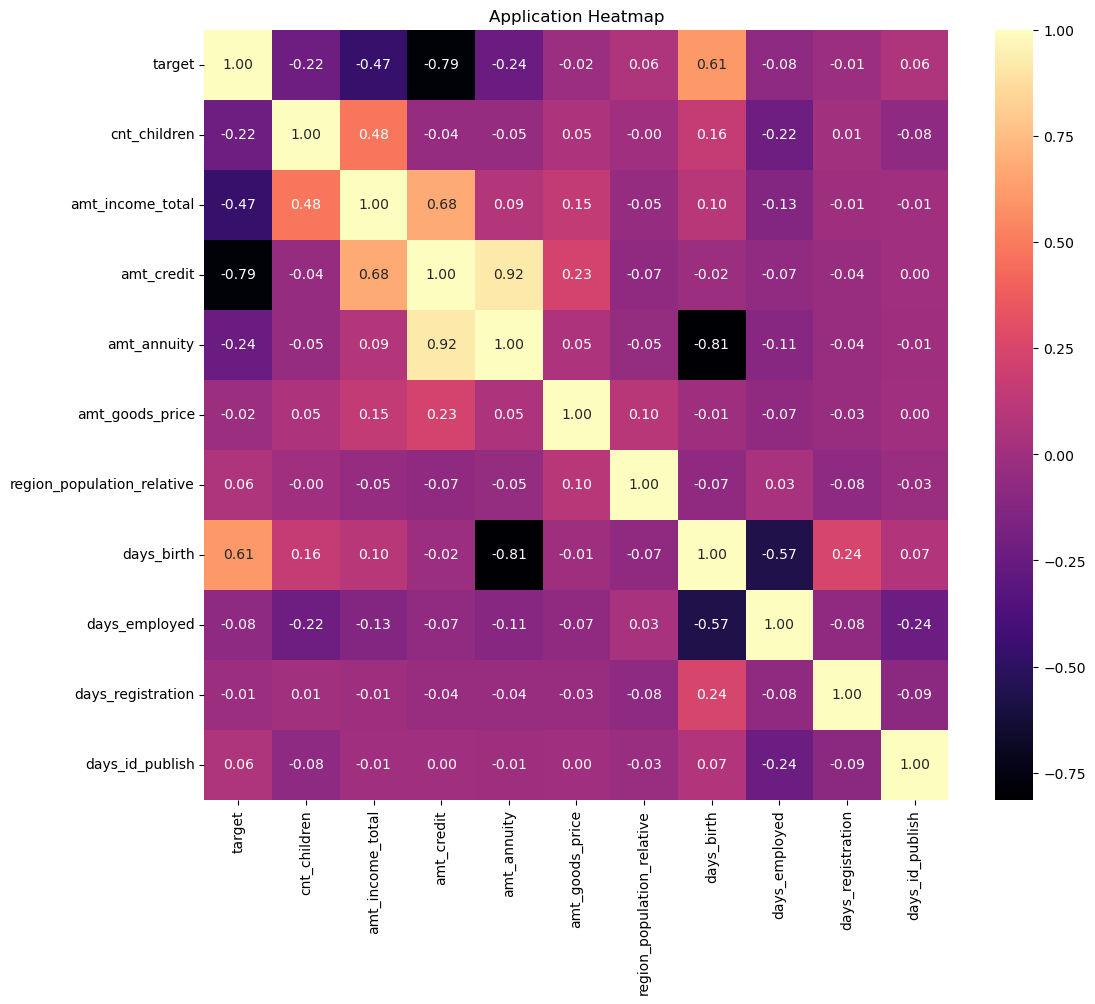

In [31]:
# Numerical columns for App DF heatmap
numerical_columns = ['target', 'cnt_children', 'amt_income_total',
                     'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative',
                     'days_birth', 'days_employed', 'days_registration', 'days_id_publish']

subset_df = app_df[numerical_columns]

# Correlation matrix
corr_matrix = subset_df.corr()

# Create Application heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f")
plt.title('Application Heatmap')
plt.show()

Bureau EDA